In [1]:
!pip install deepctr-torch
!pip install lightgbm
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 575 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.8 MB/s 
     |████████████████████████████████| 209 kB 66.3 MB/s 
     |████████████████████████████████| 81 kB 10.2 MB/s 
     |████████████████████████████████| 78 kB 10.1 MB/s 
     |████████████████████████████████| 147 kB 56.7 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
     |████████████████████████████████| 112 kB 56.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=b0f010fdf83cb8b461ba3c25e2e99c2fb1da66cd1f6582235033f0e4164df836
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a036

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


데이터 압축 풀기

In [3]:
import os
os.chdir('/content/drive/MyDrive/YDS/AIConnect_YDS_2')

In [ ]:
# rm -rf Train

In [ ]:
# !unzip train.zip

In [4]:
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer,MinMaxScaler
import matplotlib.pyplot as plt
from deepctr_torch.inputs import SparseFeat, get_feature_names, DenseFeat
from deepctr_torch.models import DeepFM
from sklearn.metrics import mean_absolute_error
import numpy as np
from lightgbm import LGBMRegressor,plot_importance,Dataset

In [5]:
# Main Train 파일 로드
Ori_Train = pd.read_csv('./Train/Train.csv', encoding='utf-8')

# 엑셀파일이기에 read_excel로 로드
Sub_Data = pd.read_excel('./Train/ETC_Data/Main_Subjects.xlsx')

# test file 업로드
test = pd.read_csv('Test.csv')

# 제출 파일 업로드
submission = pd.read_csv('Sample_Submission.csv')
submission = submission.drop(columns = ['Unnamed: 0'])

In [6]:
Basic = pd.read_excel('Train/ETC_Data/Basic.xlsx')
Detail_Info = pd.read_excel('Train/ETC_Data/Detail_Info.xlsx')
Main_Subjects = pd.read_excel('Train/ETC_Data/Main_Subjects.xlsx')
Medical_Facility = pd.read_excel('Train/ETC_Data/Medical_Facility.xlsx')
Reception_Reservation_Days = pd.read_csv('Train/ETC_Data/Reception_Reservation_Days_2022.CSV',encoding='utf-8')
Transportation = pd.read_excel('Train/ETC_Data/Transportation.xlsx')

## 추가로 고려해 볼 feature
- TIME? , 총의사수

Question_ID = USER_ID + HOSPITAL_ID = Identity_ID

In [21]:
# Primary Key 별로 진료과목 정리
Sub_Data = Sub_Data.groupby(['암호화요양기호'])['진료과목코드명'].apply(','.join).reset_index()

# 오름차순 정렬
Sub_Data['진료과목코드명'] = Sub_Data['진료과목코드명'].apply(lambda x: sorted(set(x.split(','))))

# Data Merge
Merged_Train = pd.merge(Ori_Train, Sub_Data, left_on='HOSPITAL_CD', right_on='암호화요양기호',how='left')
Merged_Train

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Identity_Key,암호화요양기호,진료과목코드명
0,0,4.778650e+05,2018-07-23 09:24:08,9.0,8.0,10.0,8.0,볼지방제거와 밴드리프팅 한지 한달됐어요 많이 가름해졌어요 좀더 지켜봐야 할것같다,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,477865_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
1,1,2.010333e+11,2018-07-23 09:59:15,10.0,10.0,10.0,10.0,너무좋은데. 아직 좀지켜봐야알겠지만 예뻐질것같은 느낌이예요,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201033325523_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
2,2,3.381810e+05,2018-07-23 10:00:57,10.0,10.0,10.0,10.0,꼭당첨!!!,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,338181_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
3,3,2.010326e+11,2018-07-24 12:57:55,5.0,6.0,6.0,4.0,무제한 보톡스 는 아닌것 같아요 보톡스를 맞기 위한 옷 이 없어 기다림 남이 입건것...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201032630325_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
4,4,4.998490e+05,2018-07-25 10:08:18,10.0,10.0,10.0,10.0,NaN,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,499849_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48433,167863,2.440542e+06,2022-09-25 04:32:05.963774,8.0,6.0,10.0,10.0,시설 좋고 선생님도 젊으세요 대신 사람이 많아서 그만큼 많이 기다려야해요 수액 놓는...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,벗이비인후과의원,...,광진구,02-6953-5805,NaN,2021-04-12 00:00:00,1,127.071848,37.534118,2440542_72069,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,"[내과, 소아청소년과, 신경과, 이비인후과]"
48434,167864,1.658243e+06,2022-09-27 01:22:27.485015,6.0,6.0,6.0,6.0,소이과 되어있어서 왔는데 소아과가 없대서 아가인고 돌아갑니다 ㅜㅜ,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,전영수내과의원,...,금천구,02-859-3500,NaN,1995-06-17 00:00:00,1,126.905218,37.479841,1658243_73445,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,"[내과, 소아청소년과]"
48435,167865,2.445760e+06,2022-09-27 05:42:37.378565,10.0,10.0,10.0,10.0,좋은말씀 많이해주세요,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,마음담은정신건강의학과의원,...,중랑구,02-2038-3070,NaN,2022-04-20 00:00:00,1,NaN,NaN,2445760_79673,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,[정신건강의학과]
48436,167866,2.452015e+06,2022-10-02 02:04:41.373758,10.0,10.0,10.0,10.0,명의이십니다 보통 한의원과는 차원이 달라요 아토피 정신과 허리 치료 받았습니다,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,다스름한의원,...,서초구,02-529-7522,NaN,2019-02-07 00:00:00,1,127.070530,37.456457,2452015_25306,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,"[사상체질과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과, 한방안·..."


In [23]:
# NaN값 처리
Merged_Train.dropna(subset=['진료과목코드명'], inplace=True)

# Merged_Train['진료과목코드명'] = Merged_Train['진료과목코드명'].fillna('X')

In [24]:
# Muliti Label Onehot
mlb = MultiLabelBinarizer()
Encoded_Value = mlb.fit_transform(Merged_Train['진료과목코드명'])
Hospital_Class = mlb.classes_
Hospital_Class = ['진료과목'+'_'+ k for k in Hospital_Class]
One_Hot_Classes = pd.DataFrame(Encoded_Value, columns = Hospital_Class)
Merged_Train = Merged_Train.drop('진료과목코드명',axis=1)

Refined_Train = pd.concat([Merged_Train, One_Hot_Classes],axis=1)

In [25]:
# test data에 없는 컬럼 제거
Refined_Train = Refined_Train.drop(columns='진료과목_비뇨기과')

In [87]:
# 학습에 활용할 모든 Column
ALL_FIELDS = ['USER_ID', 'HOSPITAL_ID', '시군구코드', 'x좌표', 'y좌표']

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Train.columns if k.startswith('진료과목')]

# 연속형 변수가 담긴 Column
CONT_FIELDS = ['x좌표','y좌표']

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS).difference(CONT_FIELDS)) + Subject_FIELDS

mms = MinMaxScaler(feature_range=(0,1))
Refined_Train[CONT_FIELDS] = mms.fit_transform(Refined_Train[CONT_FIELDS])

for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Train[feat] = lbe.fit_transform(Refined_Train[feat])

fixlen_feature_columns = [SparseFeat(feat, Refined_Train[feat].nunique()) for feat in CAT_FIELDS] + [DenseFeat(feat,1,)for feat in CONT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Train_Columns = get_feature_names(fixlen_feature_columns)
DeepFM_Train_Columns.append('TOTAL_RATE')

Final_Train = Refined_Train[DeepFM_Train_Columns]
# NaN 값 채우기
# Final_Train[Final_Train.isna().any(axis=1)]
Final_Train = Final_Train.fillna(0)
Final_Train

,USER_ID,HOSPITAL_ID,시군구코드,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,진료과목_마취통증의학과,...,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x좌표,y좌표,TOTAL_RATE
0,6201,5419,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.225242,0.932660,9.0
1,37701,5419,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.225242,0.932660,10.0
2,3855,5419,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.225242,0.932660,10.0
3,37634,5419,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.225242,0.932660,5.0
4,6739,5419,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.225242,0.932660,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48433,36589,4960,22,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.244066,0.936719,8.0
48434,33045,5064,24,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0.183371,0.924642,6.0
48435,36599,5405,18,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0.000000,10.0
48436,36613,1753,20,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,0.243586,0.919438,10.0


In [101]:
'''
 x, y 좌표 빼 보기
'''

# 학습에 활용할 모든 Column
ALL_FIELDS = ['USER_ID', 'HOSPITAL_ID', '시군구코드']

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Train.columns if k.startswith('진료과목')]

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS)) + Subject_FIELDS

mms = MinMaxScaler(feature_range=(0,1))

for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Train[feat] = lbe.fit_transform(Refined_Train[feat])

fixlen_feature_columns = [SparseFeat(feat, Refined_Train[feat].nunique()) for feat in CAT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Train_Columns = get_feature_names(fixlen_feature_columns)
DeepFM_Train_Columns.append('TOTAL_RATE')

Final_Train = Refined_Train[DeepFM_Train_Columns]
# NaN 값 채우기
# Final_Train[Final_Train.isna().any(axis=1)]
Final_Train = Final_Train.fillna(0)
Final_Train

,USER_ID,시군구코드,HOSPITAL_ID,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,진료과목_마취통증의학과,...,진료과목_한방내과,진료과목_한방부인과,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,TOTAL_RATE
0,6201,0,5419,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.0
1,37701,0,5419,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0
2,3855,0,5419,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0
3,37634,0,5419,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
4,6739,0,5419,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48433,36589,22,4960,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
48434,33045,24,5064,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0,0,6.0
48435,36599,18,5405,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0
48436,36613,20,1753,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,10.0


In [102]:
train, valid = train_test_split(Final_Train, test_size=0.2)    

In [103]:
device = 'cuda'

model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device, dnn_dropout=0.5)

model.compile(optimizer = 'adam',
              loss = 'mse',
              metrics = ['mse'])

In [104]:
train_model_input = {name: train[name]for name in DeepFM_Train_Columns}
valid_model_input = {name: valid[name]for name in DeepFM_Train_Columns}

history = model.fit(train_model_input, train['TOTAL_RATE'].values, batch_size=50, epochs=3, verbose=1, validation_split=0.2)

cuda
Train on 31000 samples, validate on 7750 samples, 620 steps per epoch


620it [00:20, 30.76it/s]


Epoch 1/3
20s - loss:  6.2591 - mse:  6.2591 - val_mse:  3.8124


620it [00:18, 33.39it/s]


Epoch 2/3
19s - loss:  2.2659 - mse:  2.2659 - val_mse:  3.9840


620it [00:20, 30.90it/s]


Epoch 3/3
21s - loss:  1.0343 - mse:  1.0343 - val_mse:  3.9820


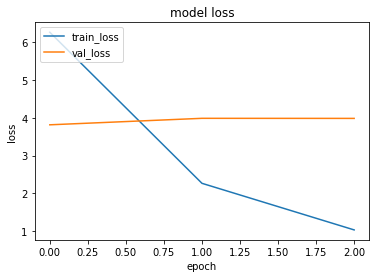

In [110]:
# 모델 결과 출력
plt.plot(history.history["loss"])
plt.plot(history.history["val_mse"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"], loc="upper left")
plt.show()

In [111]:
pred_value = model.predict(valid_model_input, 50)
predict = np.around(pred_value)
answer = valid_model_input['TOTAL_RATE']
mean_squared_error(answer, predict)

4.067093311312965

## test data 전처리

In [77]:
# train data와 같은 방식으로 Sub_Data와 Merge

Merged_Test = pd.merge(test, Sub_Data, left_on='HOSPITAL_CD',right_on='암호화요양기호',how='left')

In [ ]:
Merged_Test[Merged_Test['진료과목코드명'].isna()]

,Unnamed: 0,USER_ID,Question_ID,HOSPITAL_CD,HOSPITAL_NM,ADD,HOSPITAL_ID,TIME,요양기관명,종별코드,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Predict_Score,암호화요양기호,진료과목코드명


In [78]:
# Muliti Label Onehot
mlb = MultiLabelBinarizer()
Encoded_Value = mlb.fit_transform(Merged_Test['진료과목코드명'])
Hospital_Class = mlb.classes_
Hospital_Class = ['진료과목'+'_'+ k for k in Hospital_Class]
One_Hot_Classes = pd.DataFrame(Encoded_Value, columns = Hospital_Class)
Merged_Test = Merged_Test.drop('진료과목코드명', axis=1)

Refined_Test = pd.concat([Merged_Test, One_Hot_Classes], axis=1)

In [94]:
# 학습에 활용할 모든 Column
ALL_FIELDS = ['USER_ID', 'HOSPITAL_ID', '시군구코드', 'x좌표', 'y좌표']

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Test.columns if k.startswith('진료과목')]

# 연속형 변수가 담긴 Column
CONT_FIELDS = ['x좌표','y좌표']

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS).difference(CONT_FIELDS)) + Subject_FIELDS

mms = MinMaxScaler(feature_range=(0,1))
Refined_Test[CONT_FIELDS] = mms.fit_transform(Refined_Test[CONT_FIELDS])

for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Test[feat] = lbe.fit_transform(Refined_Test[feat])

fixlen_feature_columns = [SparseFeat(feat, Refined_Test[feat].nunique()) for feat in CAT_FIELDS] + [DenseFeat(feat,1,)for feat in CONT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Test_Columns = get_feature_names(fixlen_feature_columns)
DeepFM_Test_Columns.append('Predict_Score')

Final_Test = Refined_Test[DeepFM_Test_Columns]
# Final_Test[Final_Test.isna().any(axis=1)]

Final_Test = Final_Test.fillna(0)
Final_Test

,USER_ID,시군구코드,HOSPITAL_ID,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,진료과목_마취통증의학과,...,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x좌표,y좌표,Predict_Score
0,624,0,529,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.628586,0.399724,1
1,1167,0,215,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,0.639677,0.366401,1
2,751,0,608,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.640351,0.364644,1
3,1077,20,322,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.643883,0.348439,1
4,471,21,376,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0.747203,0.904876,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,980,20,550,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.644173,0.347710,1
1402,980,0,539,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.689858,0.439386,1
1403,980,20,631,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.645492,0.343036,1
1404,989,12,521,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.290058,0.406108,1


In [112]:
'''
x, y 좌표 빼 보기
'''

# 학습에 활용할 모든 Column
ALL_FIELDS = ['USER_ID', 'HOSPITAL_ID', '시군구코드']

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Test.columns if k.startswith('진료과목')]

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS)) + Subject_FIELDS

mms = MinMaxScaler(feature_range=(0,1))

for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Test[feat] = lbe.fit_transform(Refined_Test[feat])

fixlen_feature_columns = [SparseFeat(feat, Refined_Test[feat].nunique()) for feat in CAT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Test_Columns = get_feature_names(fixlen_feature_columns)
DeepFM_Test_Columns.append('Predict_Score')

Final_Test = Refined_Test[DeepFM_Test_Columns]
# Final_Test[Final_Test.isna().any(axis=1)]

Final_Test = Final_Test.fillna(0)
Final_Test

,USER_ID,시군구코드,HOSPITAL_ID,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,진료과목_마취통증의학과,...,진료과목_한방내과,진료과목_한방부인과,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,Predict_Score
0,624,0,529,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1167,0,215,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0,0,1
2,751,0,608,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1077,20,322,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,471,21,376,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,980,20,550,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1402,980,0,539,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1403,980,20,631,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1404,989,12,521,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [113]:
test_model_input = {name: Final_Test[name] for name in DeepFM_Test_Columns}

# history = model.fit(train_test_input, Final_Test['Predict_Score'].values, batch_size=1024, epochs=8, verbose=1, validation_split=0.2)
# history = model.fit(train_model_input, train['TOTAL_RATE'].values, batch_size=1024, epochs=8, verbose=1, validation_split=0.2)

In [122]:
pred_value = model.predict(test_model_input, 50)
predict = np.ceil(pred_value)

In [123]:
predict

array([[ 9.],
       [ 9.],
       [ 7.],
       ...,
       [10.],
       [ 9.],
       [ 9.]])

In [124]:
# 예상 값의 범위 맞춰주기

predict = np.where(predict > 10, 10, predict)
predict = np.where(predict < 0, 0, predict)

In [119]:
for i in predict:
    if i > 10:
        print(i)
    elif i < 0:
        print(i)

In [125]:
submission['Predict_Score'] = predict
submission.Predict_Score.value_counts()

10.0    446
9.0     363
8.0     300
7.0     113
6.0      96
5.0      80
4.0       8
Name: Predict_Score, dtype: int64

In [58]:
import datetime

In [126]:
# submission['Predict_Score'] = predict

path = '/content/drive/MyDrive/YDS/AIConnect_YDS_2/result/'

now = datetime.datetime.now()
submission.to_csv(f'{path}Submission_{now}.csv',encoding='utf-8', index=False)

## LGBM 추가 앙상블 모델로서 학습하기?



In [ ]:
for k in CAT_FIELDS:
    Final_Train[k]=Final_Train[k].astype('category')
    
lgbm_train_columns = get_feature_names(fixlen_feature_columns) 
    
X_train, X_test, y_train, y_test = train_test_split(Final_Train[lgbm_train_columns], Final_Train['TOTAL_RATE'], test_size=0.2, random_state = 1042)

In [ ]:
lgbm_wrapper = LGBMRegressor(n_estimators=800)
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds = 1500, eval_metric='mae', eval_set = evals, verbose=True)

[1]	valid_0's l2: 4.48394	valid_0's l1: 1.65677
Training until validation scores don't improve for 1500 rounds.
[2]	valid_0's l2: 4.37023	valid_0's l1: 1.62741
[3]	valid_0's l2: 4.27876	valid_0's l1: 1.60113
[4]	valid_0's l2: 4.20383	valid_0's l1: 1.5774
[5]	valid_0's l2: 4.14328	valid_0's l1: 1.5565
[6]	valid_0's l2: 4.09438	valid_0's l1: 1.53787
[7]	valid_0's l2: 4.05492	valid_0's l1: 1.52241
[8]	valid_0's l2: 4.02368	valid_0's l1: 1.50874
[9]	valid_0's l2: 3.99773	valid_0's l1: 1.49646
[10]	valid_0's l2: 3.97557	valid_0's l1: 1.48586
[11]	valid_0's l2: 3.95802	valid_0's l1: 1.47699
[12]	valid_0's l2: 3.94289	valid_0's l1: 1.46891
[13]	valid_0's l2: 3.93105	valid_0's l1: 1.46177
[14]	valid_0's l2: 3.92207	valid_0's l1: 1.4555
[15]	valid_0's l2: 3.91495	valid_0's l1: 1.45011
[16]	valid_0's l2: 3.90633	valid_0's l1: 1.44501
[17]	valid_0's l2: 3.89893	valid_0's l1: 1.44037
[18]	valid_0's l2: 3.89315	valid_0's l1: 1.43647
[19]	valid_0's l2: 3.88844	valid_0's l1: 1.43313
[20]	valid_0's l2

LGBMRegressor(n_estimators=800)

In [ ]:
pred = lgbm_wrapper.predict(X_test)
mean_squared_error(pred, y_test.values)

3.8171165354633634

lgbm Test Data 실험

In [ ]:
for k in CAT_FIELDS:
    Final_Test[k]=Final_Test[k].astype('category')
    
Final_Test_X = Final_Test.drop(columns=['Predict_Score'])
Final_Test_y = Final_Test.Predict_Score

In [ ]:
# test data 실험

predict = lgbm_wrapper.predict(Final_Test_X)
mean_squared_error(predict, Final_Test_y.values)

46.79072667265563

In [ ]:
predict

array([7.63216578, 8.38473775, 7.63216578, ..., 7.59674691, 8.48622643,
       8.46727594])

In [ ]:
submission['Predict_Score'] = predict

path = '/content/drive/MyDrive/YDS/AIConnect_YDS_2/result/'

now = datetime.datetime.now()
submission.to_csv(f'{path}Submission_{now}.csv',encoding='utf-8', index=False)

### 위에 사용한 Tree Model들의 Hyper Parameter는 설정하기 귀찮고 힘든데 Optuna로 설정해보는 것에 목적

In [ ]:
import matplotlib.font_manager as fm

In [ ]:
!apt -qq -y install fonts-nanum > /dev/null

In [ ]:
fm.get_fontconfig_fonts()
font_location = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()

In [ ]:
plt.rc('font', family=font_name)
print(plt.rcParams['font.family'])

['NanumBarunGothic']


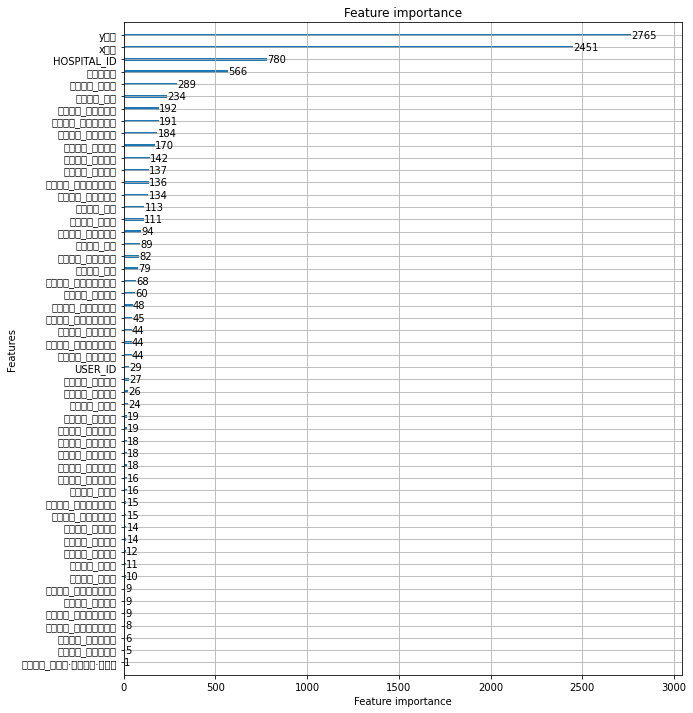

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()

### Optuna로 Tuning

In [ ]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [ ]:
sampler = TPESampler(seed=10) # 젤 많이 쓰이는 sampler, DL에서 optimizer 느낌

def objective(trial):
    dtrain = Dataset(X_train, label = y_train)
    dtest = Dataset(X_test, label = y_test)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth', 3, 50),        # suggest_int 정수로 이동하면서 학습
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2), # suggest_loguniform 함수를 써 줘야 소수점을 따라 학습
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = LGBMRegressor(**param) # ** = 가변적이라는 뜻
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
    mse = mean_squared_error(y_test, lgb_model.predict(X_test))
    return mse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2022-12-07 10:35:00,232] A new study created in memory with name: no-name-ec1f044d-ed11-4927-8bbe-f781f1f51ecd
<ipython-input-135-5b7f19e377f1>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2), # suggest_loguniform 함수를 써 줘야 소수점을 따라 학습
<ipython-input-135-5b7f19e377f1>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
[I 2022-12-07 10:35:35,786] Trial 0 finished with value: 4.623356162258303 and parameters: {'max_depth': 40, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 3205, 'min_child_samples': 76, 's

### 위 코드에서 파라미터 추출하고 추가 학습까지 진행해 줘야 함

In [ ]:
trial_params = {'max_depth': 23, 'learning_rate': 0.00990323848202835, 'n_estimators': 846, 'min_child_samples': 24, 'subsample': 0.8701277798440029}
trial_params2 = {'max_depth': 20, 'learning_rate': 0.009842725311877134, 'n_estimators': 2018, 'min_child_samples': 26, 'subsample': 0.4715832342831849}
trial_params3 = {'max_depth': 24, 'learning_rate': 0.008927289793026653, 'n_estimators': 4544, 'min_child_samples': 5, 'subsample': 0.40621052807670843}


In [ ]:
final_lgb_model = LGBMRegressor(**trial_params2)
final_lgb_model.fit(X_train, y_train)
final_lgb_pred = final_lgb_model.predict(X_test)
mean_squared_error(final_lgb_pred, y_test.values)

3.8188389885195284

In [ ]:
final_lgb_pred = final_lgb_model.predict(Final_Test_X)

In [ ]:
# around
final_lgb_pred_around = np.around(final_lgb_pred)
final_lgb_pred_around

array([8., 9., 8., ..., 8., 8., 9.])

In [ ]:
# ceil 소수점 올림
final_lgb_pred_ceil = np.ceil(final_lgb_pred)
final_lgb_pred_ceil 

array([8., 9., 8., ..., 8., 9., 9.])

In [ ]:
# trunc, 버림
final_lgb_pred_trunc = np.trunc(final_lgb_pred)
final_lgb_pred_trunc

array([7., 8., 7., ..., 7., 8., 8.])

In [ ]:
final_lgb_pred_around

array([8., 9., 8., ..., 7., 8., 9.])

In [ ]:
# 예상 값의 범위 맞춰주기, around, 반올림

final_lgb_pred_around = np.where(final_lgb_pred_around > 10, 10, final_lgb_pred_around)
final_lgb_pred_around = np.where(final_lgb_pred_around < 0, 0, final_lgb_pred_around)
submission['Predict_Score'] = final_lgb_pred_around
submission['Predict_Score'].value_counts()

8.0     1036
7.0      192
9.0      154
6.0       16
10.0       8
Name: Predict_Score, dtype: int64

In [ ]:
# 예상 값의 범위 맞춰주기, ceil

final_lgb_pred_ceil = np.where(final_lgb_pred_ceil > 10, 10, final_lgb_pred_ceil)
final_lgb_pred_ceil = np.where(final_lgb_pred_ceil < 0, 0, final_lgb_pred_ceil)
submission['Predict_Score'] = final_lgb_pred_ceil
submission['Predict_Score'].value_counts()

8.0     901
9.0     421
10.0     44
7.0      40
Name: Predict_Score, dtype: int64

In [ ]:
# 예상 값의 범위 맞춰주기, trunc

final_lgb_pred_trunc = np.where(final_lgb_pred_trunc > 10, 10, final_lgb_pred_trunc)
final_lgb_pred_trunc = np.where(final_lgb_pred_trunc < 0, 0, final_lgb_pred_trunc)
submission['Predict_Score'] = final_lgb_pred_trunc
submission['Predict_Score'].value_counts()

7.0    901
8.0    421
9.0     44
6.0     40
Name: Predict_Score, dtype: int64

In [ ]:
optuna.visualization.plot_param_importances(study_lgb)

제출

In [ ]:
submission['Predict_Score'] = final_lgb_pred_trunc

path = '/content/drive/MyDrive/YDS/AIConnect_YDS_2/result/'

now = datetime.datetime.now()
submission.to_csv(f'{path}Submission_{now}.csv',encoding='utf-8', index=False)